# KOBERT다중분류모델

### font

In [ ]:
# 나눔폰트설치 -> 런타임 재시작필요
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

### 구글드라이브 연결

In [ ]:
#구글드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### install

In [ ]:
!pip install mxnet
!pip install gluonnlp tqdm
!pip install sentencepiece
!pip install transformers
!pip install tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-qgadoqer
  Running command git clone --filter=blob:none --quiet 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-qgadoqer
  Resolved https://****@github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done


### import

In [ ]:
# os
import os

# torch
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

# kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup


### GPU/CPU설정

In [ ]:
device = torch.device("cuda:0") #GPU사용
# device = torch.device("cpu")  #CPU사용

In [ ]:
bertmodel, vocab = get_pytorch_kobert_model()

using cached model. /content/.cache/kobert_v1.zip
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


### Mecab DATA 불러오기

In [ ]:
#데이터불러오기
import pandas as pd
df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/refer_data/크롤링이후/clean_total_crawling10.2(1500개씩뽑은데이터).csv', encoding='utf8')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24785 entries, 0 to 24784
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index_num    24785 non-null  int64 
 1   reviews      24785 non-null  object
 2   keyword_kor  24785 non-null  object
 3   keyword_num  24785 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 774.7+ KB


In [ ]:
# 각 클래스별 데이터 수 확인
print(df2['keyword_kor'].value_counts())

곱창       1500
아시아음식    1500
한식       1500
타코       1500
중식       1500
전골       1500
양식       1500
스시       1500
분식       1500
베이커리     1500
버거       1500
라멘       1500
디저트      1500
해산물      1500
국수       1474
치킨       1254
돈카츠      1057
Name: keyword_kor, dtype: int64


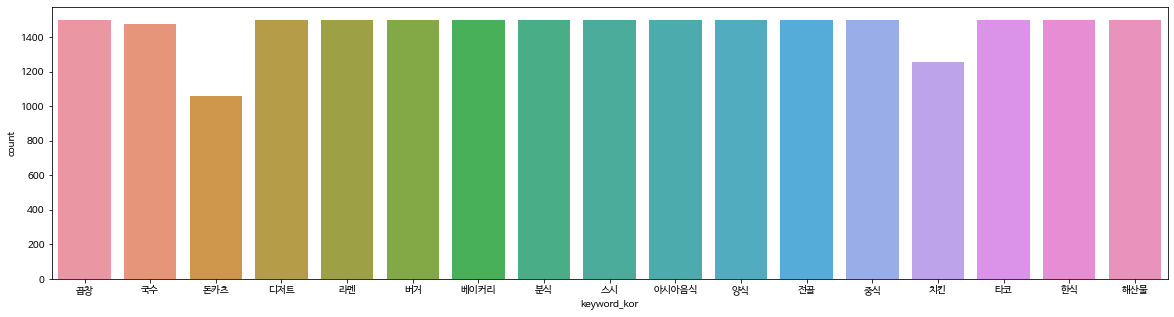

In [ ]:
# 각 클래스별 데이터분포 확인
import seaborn as sns
import matplotlib.pyplot as plt

#한글폰트설정
plt.rc('font', family='NanumBarunGothic')
#출력그래프설정
sns.countplot(data=df2, x='keyword_kor')
#사이즈설정
plt.rcParams["figure.figsize"] = (20, 5)
plt.grid(False)
plt.show()

In [ ]:
#데이터불러오기
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/refer_data/형태소분석데이터/clean_total_mecab.csv', encoding='utf8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51034 entries, 0 to 51033
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Column1      51034 non-null  int64 
 1   reviews      51034 non-null  object
 2   keyword_kor  51034 non-null  object
 3   keyword_num  51034 non-null  int64 
 4   글자수          51034 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.9+ MB


In [ ]:
# 각 클래스별 데이터 수 확인
print(df['keyword_kor'].value_counts())

한식       9090
디저트      5861
버거       3949
중식       3772
분식       3559
양식       3221
라멘       3051
해산물      2803
베이커리     2668
스시       2396
전골       2243
아시아음식    1843
곱창       1695
타코       1414
국수       1367
치킨       1177
돈카츠       925
Name: keyword_kor, dtype: int64


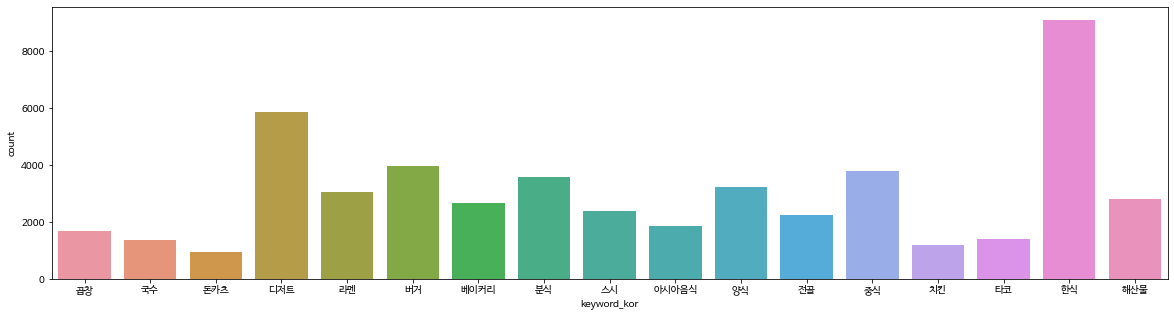

In [ ]:
# 각 클래스별 데이터분포 확인
import seaborn as sns
import matplotlib.pyplot as plt

#한글폰트설정
plt.rc('font', family='NanumBarunGothic')
#출력그래프설정
sns.countplot(data=df, x='keyword_kor')
#사이즈설정
plt.rcParams["figure.figsize"] = (20, 5)
plt.grid(False)
plt.show()

In [ ]:
data_list = []
for q, label in zip(df['reviews'], df['keyword_num'])  :
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)

#train & test 데이터로 나누기
from sklearn.model_selection import train_test_split                                  
dataset_train, dataset_test = train_test_split(data_list, test_size=0.20, random_state=0) #8:2로 나눔

print(len(dataset_train))
print(len(dataset_test))

40827
10207


In [ ]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len, pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [ ]:
l1 = [len(i[0]) for i in dataset_train]
l2 = [len(i[0]) for i in dataset_test]
max(max(l1),max(l2))

5079

## 파라미터값

In [ ]:
## Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 20
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5, shuffle=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## 모델구성

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=17,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        #valid_length 까지만 1, 나머지는 0으로 mask를 생성
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        # return_dict=False 추가
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device), return_dict=False)

        #pooler는 CLS토큰에 대한 임베딩의 결과, 단순히 첫번째 토큰에 대한 결과가 아니라 문맥을 알아내기 위한 추가 layer를 통과한다.(아마도?)
        #임베딩의 결과에 linear layer를 통과시켜서 classification을 진행한다.
        # print(pooler.shape) batchsize * 768

        #_는 64개(max_length)의 모든 토큰에 대한 임베딩의 결과
        #단어 임베딩을 알고 싶을 때 사용할 수 있다.
        #_의 첫번째 값과 pooler와는 다른 값을 가지고 있는데 pooler는 _의 첫번째 값의 추가적으로 한번더 과정을 거친다.
        #print(_.shape) batchsize * max_len * 768

        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out) #batchsize * num_classes

In [ ]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

In [ ]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [ ]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [ ]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [ ]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

## 모델학습

In [ ]:
from tqdm.notebook import tqdm
train_history=[]
test_history=[]
loss_history=[]

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)

        #print(label.shape,out.shape)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
            train_history.append(train_acc / (batch_id+1)) #train_acc 저장
            loss_history.append(loss.data.cpu().numpy())   #train_loss 저장
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    train_history.append(train_acc / (batch_id+1))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    test_history.append(test_acc / (batch_id+1)) #test_acc 저장

<ipython-input-23-ef19cb19538b>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/638 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 2.919203281402588 train acc 0.046875
epoch 1 batch id 201 loss 2.6214165687561035 train acc 0.13588308457711443
epoch 1 batch id 401 loss 1.8739780187606812 train acc 0.23936253117206982
epoch 1 batch id 601 loss 1.5043641328811646 train acc 0.35084754575707155
epoch 1 train acc 0.3681256143403645


<ipython-input-23-ef19cb19538b>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/160 [00:00<?, ?it/s]

epoch 1 test acc 0.6629504788306452


  0%|          | 0/638 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.3699249029159546 train acc 0.65625
epoch 2 batch id 201 loss 1.5488914251327515 train acc 0.6771610696517413
epoch 2 batch id 401 loss 0.8722477555274963 train acc 0.6883961970074813
epoch 2 batch id 601 loss 1.0904072523117065 train acc 0.6950135191347754
epoch 2 train acc 0.6957670288507518


  0%|          | 0/160 [00:00<?, ?it/s]

epoch 2 test acc 0.7252236643145161


  0%|          | 0/638 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.9259044528007507 train acc 0.734375
epoch 3 batch id 201 loss 0.842736542224884 train acc 0.7339085820895522
epoch 3 batch id 401 loss 0.674264669418335 train acc 0.737998753117207
epoch 3 batch id 601 loss 0.9626501202583313 train acc 0.7400946339434277
epoch 3 train acc 0.740197120238032


  0%|          | 0/160 [00:00<?, ?it/s]

epoch 3 test acc 0.7322549143145161


  0%|          | 0/638 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.5859472751617432 train acc 0.84375
epoch 4 batch id 201 loss 0.8268483877182007 train acc 0.7768190298507462
epoch 4 batch id 401 loss 0.6182287335395813 train acc 0.7813668952618454
epoch 4 batch id 601 loss 0.9364970326423645 train acc 0.781198003327787
epoch 4 train acc 0.7815700381223102


  0%|          | 0/160 [00:00<?, ?it/s]

epoch 4 test acc 0.750749747983871


  0%|          | 0/638 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.47730475664138794 train acc 0.84375
epoch 5 batch id 201 loss 0.6376854777336121 train acc 0.8187966417910447
epoch 5 batch id 401 loss 0.8028258681297302 train acc 0.8170199501246883
epoch 5 batch id 601 loss 0.47958290576934814 train acc 0.8192335690515807
epoch 5 train acc 0.8185529129695553


  0%|          | 0/160 [00:00<?, ?it/s]

epoch 5 test acc 0.757976310483871


  0%|          | 0/638 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.7175309658050537 train acc 0.78125
epoch 6 batch id 201 loss 0.4067263901233673 train acc 0.8575093283582089
epoch 6 batch id 401 loss 0.5183629393577576 train acc 0.8514650872817955
epoch 6 batch id 601 loss 0.4147482216358185 train acc 0.852303452579035
epoch 6 train acc 0.8524275576483715


  0%|          | 0/160 [00:00<?, ?it/s]

epoch 6 test acc 0.7579574092741935


  0%|          | 0/638 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.37123093008995056 train acc 0.890625
epoch 7 batch id 201 loss 0.2824442386627197 train acc 0.878731343283582
epoch 7 batch id 401 loss 0.7793626189231873 train acc 0.8811175187032418
epoch 7 batch id 601 loss 0.4791610538959503 train acc 0.8802516638935108
epoch 7 train acc 0.8797407981775676


  0%|          | 0/160 [00:00<?, ?it/s]

epoch 7 test acc 0.7443768901209677


  0%|          | 0/638 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.4607852101325989 train acc 0.875
epoch 8 batch id 201 loss 0.5402767658233643 train acc 0.9078824626865671
epoch 8 batch id 401 loss 0.40351414680480957 train acc 0.9065227556109726
epoch 8 batch id 601 loss 0.5205607414245605 train acc 0.9043781198003328
epoch 8 train acc 0.9050885646352478


  0%|          | 0/160 [00:00<?, ?it/s]

epoch 8 test acc 0.7618951612903226


  0%|          | 0/638 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.1769566684961319 train acc 0.9375
epoch 9 batch id 201 loss 0.19728983938694 train acc 0.9306592039800995
epoch 9 batch id 401 loss 0.161875382065773 train acc 0.9286938902743143
epoch 9 batch id 601 loss 0.18556742370128632 train acc 0.927932612312812
epoch 9 train acc 0.9279179506933745


  0%|          | 0/160 [00:00<?, ?it/s]

epoch 9 test acc 0.7564862651209677


  0%|          | 0/638 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.18906939029693604 train acc 0.9375
epoch 10 batch id 201 loss 0.14434465765953064 train acc 0.9446517412935324
epoch 10 batch id 401 loss 0.1824062317609787 train acc 0.9449812967581047
epoch 10 batch id 601 loss 0.2507920563220978 train acc 0.9452475041597338
epoch 10 train acc 0.9448592164337708


  0%|          | 0/160 [00:00<?, ?it/s]

epoch 10 test acc 0.756023185483871


  0%|          | 0/638 [00:00<?, ?it/s]

epoch 11 batch id 1 loss 0.19262418150901794 train acc 0.953125
epoch 11 batch id 201 loss 0.07346861809492111 train acc 0.9591884328358209
epoch 11 batch id 401 loss 0.44997429847717285 train acc 0.9589697630922693
epoch 11 batch id 601 loss 0.05753939598798752 train acc 0.959234608985025
epoch 11 train acc 0.9593373093884491


  0%|          | 0/160 [00:00<?, ?it/s]

epoch 11 test acc 0.751694808467742


  0%|          | 0/638 [00:00<?, ?it/s]

epoch 12 batch id 1 loss 0.10884640365839005 train acc 0.96875
epoch 12 batch id 201 loss 0.09266123175621033 train acc 0.9701492537313433
epoch 12 batch id 401 loss 0.10175368934869766 train acc 0.9694903366583542
epoch 12 batch id 601 loss 0.05367070809006691 train acc 0.9685680116472546
epoch 12 train acc 0.968600980952128


  0%|          | 0/160 [00:00<?, ?it/s]

epoch 12 test acc 0.7609910534274194


  0%|          | 0/638 [00:00<?, ?it/s]

epoch 13 batch id 1 loss 0.09762534499168396 train acc 0.96875
epoch 13 batch id 201 loss 0.12290196120738983 train acc 0.9785447761194029
epoch 13 batch id 401 loss 0.12435601651668549 train acc 0.9789198877805486
epoch 13 batch id 601 loss 0.298675000667572 train acc 0.9783953826955075
epoch 13 train acc 0.978642125152755


  0%|          | 0/160 [00:00<?, ?it/s]

epoch 13 test acc 0.7535754788306452


  0%|          | 0/638 [00:00<?, ?it/s]

epoch 14 batch id 1 loss 0.04625043272972107 train acc 0.984375
epoch 14 batch id 201 loss 0.01918896473944187 train acc 0.9850746268656716
epoch 14 batch id 401 loss 0.0046993400901556015 train acc 0.9852322319201995
epoch 14 batch id 601 loss 0.011104601435363293 train acc 0.985596921797005
epoch 14 train acc 0.9854015295414696


  0%|          | 0/160 [00:00<?, ?it/s]

epoch 14 test acc 0.7570722026209677


  0%|          | 0/638 [00:00<?, ?it/s]

epoch 15 batch id 1 loss 0.012263181619346142 train acc 1.0
epoch 15 batch id 201 loss 0.01524290256202221 train acc 0.9898942786069652
epoch 15 batch id 401 loss 0.016071867197752 train acc 0.9911159600997507
epoch 15 batch id 601 loss 0.026399120688438416 train acc 0.9907185940099834
epoch 15 train acc 0.9908160266457681


  0%|          | 0/160 [00:00<?, ?it/s]

epoch 15 test acc 0.7595199092741935


  0%|          | 0/638 [00:00<?, ?it/s]

epoch 16 batch id 1 loss 0.0029219435527920723 train acc 1.0
epoch 16 batch id 201 loss 0.003698921762406826 train acc 0.9935478855721394
epoch 16 batch id 401 loss 0.004792878869920969 train acc 0.9945838528678305
epoch 16 batch id 601 loss 0.012967489659786224 train acc 0.9947483361064892
epoch 16 train acc 0.9947345219435737


  0%|          | 0/160 [00:00<?, ?it/s]

epoch 16 test acc 0.7539598034274194


  0%|          | 0/638 [00:00<?, ?it/s]

epoch 17 batch id 1 loss 0.0024301616940647364 train acc 1.0
epoch 17 batch id 201 loss 0.07307104021310806 train acc 0.9951803482587065
epoch 17 batch id 401 loss 0.0014349849661812186 train acc 0.9959086658354115
epoch 17 batch id 601 loss 0.0010790996020659804 train acc 0.9959442595673876
epoch 17 train acc 0.9960080329153606


  0%|          | 0/160 [00:00<?, ?it/s]

epoch 17 test acc 0.7609784526209677


  0%|          | 0/638 [00:00<?, ?it/s]

epoch 18 batch id 1 loss 0.044698119163513184 train acc 0.984375
epoch 18 batch id 201 loss 0.0012818888062611222 train acc 0.9970460199004975
epoch 18 batch id 401 loss 0.004496408626437187 train acc 0.9971165835411472
epoch 18 batch id 601 loss 0.0045584142208099365 train acc 0.9969841930116472
epoch 18 train acc 0.9971590909090909


  0%|          | 0/160 [00:00<?, ?it/s]

epoch 18 test acc 0.7595262096774194


  0%|          | 0/638 [00:00<?, ?it/s]

epoch 19 batch id 1 loss 0.0021919768769294024 train acc 1.0
epoch 19 batch id 201 loss 0.0024238780606538057 train acc 0.9975901741293532
epoch 19 batch id 401 loss 0.0025560546200722456 train acc 0.9976620947630923
epoch 19 batch id 601 loss 0.007965470664203167 train acc 0.9978681364392679
epoch 19 train acc 0.9978693181818182


  0%|          | 0/160 [00:00<?, ?it/s]

epoch 19 test acc 0.762077872983871


  0%|          | 0/638 [00:00<?, ?it/s]

epoch 20 batch id 1 loss 0.0010082385269924998 train acc 1.0
epoch 20 batch id 201 loss 0.0013117409544065595 train acc 0.9982898009950248
epoch 20 batch id 401 loss 0.0022625422570854425 train acc 0.9982076059850374
epoch 20 batch id 601 loss 0.0033574127592146397 train acc 0.9979461314475874
epoch 20 train acc 0.9979182993730408


  0%|          | 0/160 [00:00<?, ?it/s]

epoch 20 test acc 0.7618510584677419


In [ ]:
import pandas as pd

# 과학적 표기법 대신 소수점 5자리까지 나타낸다.
pd.options.display.float_format = '{:.5f}'.format
#다시 원래대로 옵션을 변경하고 싶을 때는 아래 명령어를 사용하면 됩니다.
# pd.reset_option('display.float_format')

In [ ]:
def softmax(vals, idx):
    valscpu = vals.detach().cpu().squeeze(0)
    a = 0
    for i in valscpu:
        a += np.exp(i)
    return ((np.exp(valscpu[idx]))/a).item() * 100

In [ ]:
def testModel(model, seq):
    cate = ["곱창","국수","돈카츠", "디저트","라멘","버거", "베이커리", "분식", "스시", "아시아음식", "양식", "전골", "중식", "치킨", "타코", "한식", "해산물"]
    tmp = [seq]
    transform = nlp.data.BERTSentenceTransform(tok, max_len, pad=True, pair=False)
    tokenized = transform(tmp)

    modelload.eval()
    result = modelload(torch.tensor([tokenized[0]]).to(device), [tokenized[1]], torch.tensor(tokenized[2]).to(device)) 
    idx = result.argmax().cpu().item() #출력의 최대값이 나오게함
    result2 = F.softmax(result, dim=1).sort() #각 값에 대한 softmax함수 적용
    print('추천하는 TOP3 카테고리&신뢰도:','\n','\n',cate[result2[1][0][-1]],round((result2[0][0][-1]).item(), 4)*100,'%','\n','\n',cate[result2[1][0][-2]],round((result2[0][0][-2]).item(), 4)*100,'%','\n','\n',cate[result2[1][0][-3]],round((result2[0][0][-3]).item(), 4)*100,'%', '\n') #dndices 값에서는 클래스가 하나씩 밀렸기에 결과값+1로 판단
    print('-'*150)
    print(f"최종 분석결과 가장 적합한 음식은 '{cate[idx]}'이며,", "문장 신뢰도는","{:.2f}%".format(softmax(result,idx)),"입니다.")
    #print('모든 클래스의 텐서 값:',result) #모든 클래스에 대한 softmax 값이 도출

In [ ]:
#########################################모델 저장 및 불러오기 파트############################################################
# 방법1)
# 저장
torch.save(model,"/content/drive/MyDrive/Colab Notebooks/Save_data/모델분석/코버트/model6.pt")  # 전체 모델 저장

In [ ]:
# 불러오기
# 전체 모델을 통째로 불러옴, 모델 클래스 선언 필수
# modelload = torch.load("/content/drive/MyDrive/Colab Notebooks/Save_data/모델분석/코버트/model6(1epochs).pt", map_location=torch.device('cpu')) # cpu사용시
modelload = torch.load("/content/drive/MyDrive/Colab Notebooks/Save_data/모델분석/코버트/model6.pt") # gpu사용시
modelload.eval()

In [ ]:
testModel(model, "분위기 좋고 야채없이 패티와 치즈만 선택해서 버거로 먹을 수 있는 것도 특이하고 무엇보다 맥앤치즈가 짱")

추천하는 TOP3 카테고리&신뢰도: 
 
 버거 99.94 % 
 
 돈카츠 0.01 % 
 
 베이커리 0.01 % 

------------------------------------------------------------------------------------------------------------------------------------------------------
최종 분석결과 가장 적합한 음식은 '버거'이며, 문장 신뢰도는 99.94% 입니다.


In [ ]:
testModel(model, "육즙이 팡팡 터지는 고소한 음식이 먹고싶어")

추천하는 TOP3 카테고리&신뢰도: 
 
 양식 99.85000000000001 % 
 
 타코 0.05 % 
 
 아시아음식 0.02 % 

------------------------------------------------------------------------------------------------------------------------------------------------------
최종 분석결과 가장 적합한 음식은 '양식'이며, 문장 신뢰도는 99.85% 입니다.


In [ ]:
testModel(model, "남부 유럽의 전통적인 특색을 살리면서도 너무 자극적이지 않은 음식이 생각납니다. 해안 음식이 들어가지 않고 육지 음식이 메인이면서도 너무 묵직하지 않고 가벼운 느낌이 나면 좋을 것 같아요. 유럽 특유의 향신료가 가볍게 들어가는 것은 좋지만 너무 진하여 음식 본유의 맛이 깨지지 않는 음식으로 부탁합니다.")

tensor([[-1.4854, -2.1195, -1.2237, -0.4130, -0.7334, -0.1584,  0.0786, -0.3642,
          0.2487, -1.2310,  9.8988, -0.8291, -1.3258, -0.6285,  0.0507, -2.1096,
          0.8154]], device='cuda:0', grad_fn=<AddmmBackward0>)
torch.return_types.sort(
values=tensor([[6.0295e-06, 6.0894e-06, 1.1368e-05, 1.3334e-05, 1.4661e-05, 1.4768e-05,
         2.1912e-05, 2.4113e-05, 2.6779e-05, 3.3219e-05, 3.4882e-05, 4.2851e-05,
         5.2819e-05, 5.4310e-05, 6.4384e-05, 1.1347e-04, 9.9947e-01]],
       device='cuda:0', grad_fn=<SortBackward0>),
indices=tensor([[ 1, 15,  0, 12,  9,  2, 11,  4, 13,  3,  7,  5, 14,  6,  8, 16, 10]],
       device='cuda:0'))
추천 카테고리는: 양식
신뢰도는: 99.95%


In [ ]:
testModel(model, "남부 유럽의 전통적인 특색을 살리면서도 너무 자극적이지 않은 음식이 생각납니다. 해안 음식이 들어가지 않고 육지 음식이 메인이면서도 너무 묵직하지 않고 가벼운 느낌이 나면 좋을 것 같아요. 유럽 특유의 향신료가 가볍게 들어가는 것은 좋지만 너무 진하여 음식 본유의 맛이 깨지지 않는 음식으로 부탁합니다.")

tensor([[-1.2830, -1.0919, -0.3407, -0.2743,  0.2394,  1.5249, -1.1723, -0.7491,
          0.8002,  0.1180,  2.4597, -0.7941,  0.3738, -1.2144,  1.5786,  0.0343,
          1.3911, -2.2925]], grad_fn=<AddmmBackward0>)
torch.return_types.sort(
values=tensor([[0.0028, 0.0077, 0.0082, 0.0086, 0.0093, 0.0126, 0.0131, 0.0198, 0.0211,
         0.0288, 0.0313, 0.0353, 0.0404, 0.0618, 0.1117, 0.1277, 0.1347, 0.3251]],
       grad_fn=<SortBackward0>),
indices=tensor([[17,  0, 13,  6,  1, 11,  7,  2,  3, 15,  9,  4, 12,  8, 16,  5, 14, 10]]))
추천 카테고리는: 양식
신뢰도는: 32.51%


In [ ]:
testModel(model,'입에 넣어서 씹자마자 육즙이 팡팡터지고 씹으면 씹을수록 고소함과 감칠맛을 느낄수 있는 음식이 먹고싶어요')

tensor([[-1.2732,  3.1749, -0.1065, -0.3420, -0.9201, -1.4652,  0.2968, -2.9234,
         -1.4805,  5.5873, -0.3603,  3.1473,  2.5414, -1.6682,  1.0608, -2.0417,
         -2.4238]], device='cuda:0', grad_fn=<AddmmBackward0>)
torch.return_types.sort(
values=tensor([[1.6042e-04, 2.6439e-04, 3.8743e-04, 5.6284e-04, 6.7905e-04, 6.8956e-04,
         8.3548e-04, 1.1893e-03, 2.0817e-03, 2.1201e-03, 2.6831e-03, 4.0158e-03,
         8.6217e-03, 3.7897e-02, 6.9458e-02, 7.1407e-02, 7.9695e-01]],
       device='cuda:0', grad_fn=<SortBackward0>),
indices=tensor([[ 7, 16, 15, 13,  8,  5,  0,  4, 10,  3,  2,  6, 14, 12, 11,  1,  9]],
       device='cuda:0'))
추천 카테고리는: 아시아음식
신뢰도는: 79.69%


In [ ]:
testModel(model,'말랑하고 쫀득하면서 매콤한 음식이 땡기고 달짝지근한 음식 없을까')

tensor([[ 0.6910, -0.5917, -0.7359, -0.7021, -1.8168, -1.1164, -1.2773,  9.9754,
         -1.1736, -2.7342, -0.1401,  0.7301, -0.6098, -0.7408, -0.9994,  0.8516,
          0.3699]], device='cuda:0', grad_fn=<AddmmBackward0>)
torch.return_types.sort(
values=tensor([[3.0199e-06, 7.5586e-06, 1.2964e-05, 1.4380e-05, 1.5227e-05, 1.7117e-05,
         2.2169e-05, 2.2278e-05, 2.3043e-05, 2.5273e-05, 2.5735e-05, 4.0421e-05,
         6.7314e-05, 9.2804e-05, 9.6503e-05, 1.0897e-04, 9.9941e-01]],
       device='cuda:0', grad_fn=<SortBackward0>),
indices=tensor([[ 9,  4,  6,  8,  5, 14, 13,  2,  3, 12,  1, 10, 16,  0, 11, 15,  7]],
       device='cuda:0'))
추천 카테고리는: 분식
신뢰도는: 99.94%


In [ ]:
testModel(model,'기름지고 마늘향이 나는 파스타가 먹고싶어')

tensor([[-1.2425, -2.1167, -1.5662, -0.3091, -1.4362,  0.7812,  1.0787, -0.9444,
          0.1469, -0.3899,  9.7375, -1.2119, -1.6448, -0.7991, -0.0516, -2.2873,
          0.6442]], device='cuda:0', grad_fn=<AddmmBackward0>)
torch.return_types.sort(
values=tensor([[5.9896e-06, 7.1038e-06, 1.1388e-05, 1.2319e-05, 1.4029e-05, 1.7027e-05,
         1.7557e-05, 2.2941e-05, 2.6529e-05, 3.9941e-05, 4.3301e-05, 5.6018e-05,
         6.8322e-05, 1.1233e-04, 1.2883e-04, 1.7347e-04, 9.9924e-01]],
       device='cuda:0', grad_fn=<SortBackward0>),
indices=tensor([[15,  1, 12,  2,  4,  0, 11,  7, 13,  9,  3, 14,  8, 16,  5,  6, 10]],
       device='cuda:0'))
추천 카테고리는: 양식
신뢰도는: 99.92%


In [ ]:
testModel(model,'요즘 매운 음식만 먹다보니까 배가 자주 아파서 오늘은 담백한 음식을 먹어야겠어 그리고 부모님과 함께 먹을거니까 정갈하게 차려진 음식은 뭐가 있을까')

tensor([[ 1.0600e-02,  6.8903e-01, -2.1221e+00, -1.5065e+00, -8.6744e-01,
         -1.9720e+00, -1.9527e+00,  3.5640e-01, -1.1397e+00, -1.8341e+00,
         -1.6196e+00,  1.1375e+00, -1.0502e+00, -5.9234e-01, -2.4400e+00,
          1.0797e+01,  1.9977e+00]], device='cuda:0', grad_fn=<AddmmBackward0>)
torch.return_types.sort(
values=tensor([[1.7823e-06, 2.4495e-06, 2.8462e-06, 2.9017e-06, 3.2670e-06, 4.0487e-06,
         4.5336e-06, 6.5423e-06, 7.1549e-06, 8.5894e-06, 1.1309e-05, 2.0668e-05,
         2.9206e-05, 4.0732e-05, 6.3782e-05, 1.5076e-04, 9.9964e-01]],
       device='cuda:0', grad_fn=<SortBackward0>),
indices=tensor([[14,  2,  5,  6,  9, 10,  3,  8, 12,  4, 13,  0,  7,  1, 11, 16, 15]],
       device='cuda:0'))
추천 카테고리는: 한식
신뢰도는: 99.96%


In [ ]:
testModel(model,'붉은 빛이 은은하게 도는 그것은 참 중독성이 강한 맛이었어요. 맛 자체가 굉장히 신비롭지는 않지만 적당히 매콤한 맛이 계속 입 맛에 맴도니까 수저가 그것을 향해 가게 되더군요. 단순히 매콤한 맛 뿐만 아니라 적당한 단맛과 감칠맛이 가미되니 단순하면서도 깊이 있는 맛이 된 것이 아닐까 생각합니다. 어머니가 자주 끓여주시던 그 음식을 서울에서 다시 맛 볼 수 있을까요?')

tensor([[-1.4058, -1.9163,  6.3417,  3.4678,  0.1138, -1.0132, -0.2565,  2.2905,
         -0.6212,  0.2297,  0.1196, -0.2220, -1.3668,  0.9501,  0.4884, -3.0033,
         -2.4903]], device='cuda:0', grad_fn=<AddmmBackward0>)
torch.return_types.sort(
values=tensor([[7.9947e-05, 1.3353e-04, 2.3707e-04, 3.9499e-04, 4.1068e-04, 5.8490e-04,
         8.6563e-04, 1.2466e-03, 1.2903e-03, 1.8052e-03, 1.8157e-03, 2.0271e-03,
         2.6257e-03, 4.1661e-03, 1.5918e-02, 5.1661e-02, 9.1474e-01]],
       device='cuda:0', grad_fn=<SortBackward0>),
indices=tensor([[15, 16,  1,  0, 12,  5,  8,  6, 11,  4, 10,  9, 14, 13,  7,  3,  2]],
       device='cuda:0'))
추천 카테고리는: 돈카츠
신뢰도는: 91.47%


In [ ]:
testModel(model,'1년전에 일본여행에서 먹었던 고기의 맛이 잊혀지지 않는데 그때 먹었던 바삭바삭한 튀김옷과 부드러운 육질을 느낄 수 있는 음식 추천해줘')

tensor([[-1.8113, -0.9818,  5.6330, -0.6698,  9.1771,  0.1647, -1.3812,  0.3821,
         -0.4495, -1.2185, -0.7798, -1.3205, -0.3692, -1.0963,  0.4408, -1.0541,
         -1.9645]], device='cuda:0', grad_fn=<AddmmBackward0>)
torch.return_types.sort(
values=tensor([[1.4078e-05, 1.6408e-05, 2.5227e-05, 2.6805e-05, 2.9684e-05, 3.3541e-05,
         3.4988e-05, 3.7609e-05, 4.6028e-05, 5.1381e-05, 6.4044e-05, 6.9397e-05,
         1.1837e-04, 1.4711e-04, 1.5600e-04, 2.8060e-02, 9.7107e-01]],
       device='cuda:0', grad_fn=<SortBackward0>),
indices=tensor([[16,  0,  6, 11,  9, 13, 15,  1, 10,  3,  8, 12,  5,  7, 14,  2,  4]],
       device='cuda:0'))
추천 카테고리는: 라멘
신뢰도는: 97.11%


In [ ]:
testModel(model,'매콤달달한거 먹고싶어')

tensor([[-0.1963,  0.9873, -0.4727, -2.2199, -0.9946, -2.2160, -1.9525,  9.0203,
         -1.3659, -3.5034, -0.9877,  0.9390, -1.9246, -0.3947, -1.3703,  3.9437,
          1.6849]], device='cuda:0', grad_fn=<AddmmBackward0>)
torch.return_types.sort(
values=tensor([[3.6106e-06, 1.3031e-05, 1.3082e-05, 1.7026e-05, 1.7508e-05, 3.0477e-05,
         3.0609e-05, 4.4373e-05, 4.4682e-05, 7.4778e-05, 8.0849e-05, 9.8590e-05,
         3.0682e-04, 3.2200e-04, 6.4684e-04, 6.1916e-03, 9.9206e-01]],
       device='cuda:0', grad_fn=<SortBackward0>),
indices=tensor([[ 9,  3,  5,  6, 12, 14,  8,  4, 10,  2, 13,  0, 11,  1, 16, 15,  7]],
       device='cuda:0'))
추천 카테고리는: 분식
신뢰도는: 99.21%


In [ ]:
testModel(model,'친구랑 술 한잔하기 좋은 음식 추천해줘')

tensor([[ 0.1255, -1.8297, -3.1192,  1.2302, -1.7988, -2.1800, -1.3780, -0.1627,
          0.3791,  2.2272, -0.1338,  4.7062,  3.3931, -2.7576,  0.9940, -1.4438,
          3.8217]], device='cuda:0', grad_fn=<AddmmBackward0>)
torch.return_types.sort(
values=tensor([[2.1367e-04, 3.0675e-04, 5.4656e-04, 7.7583e-04, 8.0023e-04, 1.1412e-03,
         1.2188e-03, 4.1093e-03, 4.2295e-03, 5.4815e-03, 7.0643e-03, 1.3065e-02,
         1.6546e-02, 4.4838e-02, 1.4388e-01, 2.2087e-01, 5.3491e-01]],
       device='cuda:0', grad_fn=<SortBackward0>),
indices=tensor([[ 2, 13,  5,  1,  4, 15,  6,  7, 10,  0,  8, 14,  3,  9, 12, 16, 11]],
       device='cuda:0'))
추천 카테고리는: 전골
신뢰도는: 53.49%


In [ ]:
testModel(model,'친구에게 햄최몇을 물어보면서 먹을 수 있는 음식 추천해줘')

tensor([[-0.9975, -1.7291,  0.2451,  0.9866, -0.3827, 10.2090,  0.6131, -0.7356,
         -1.0395, -0.6330, -0.3732, -2.8522, -1.2112, -0.4348,  0.1008, -1.2046,
         -2.3326]], device='cuda:0', grad_fn=<AddmmBackward0>)
torch.return_types.sort(
values=tensor([[2.1252e-06, 3.5734e-06, 6.5339e-06, 1.0968e-05, 1.1040e-05, 1.3021e-05,
         1.3580e-05, 1.7646e-05, 1.9552e-05, 2.3839e-05, 2.5114e-05, 2.5353e-05,
         4.0729e-05, 4.7052e-05, 6.7983e-05, 9.8764e-05, 9.9957e-01]],
       device='cuda:0', grad_fn=<SortBackward0>),
indices=tensor([[11, 16,  1, 12, 15,  8,  0,  7,  9, 13,  4, 10, 14,  2,  6,  3,  5]],
       device='cuda:0'))
추천 카테고리는: 버거
신뢰도는: 99.96%


In [ ]:
testModel(model,'후루룩 먹을 수 있는 국물이 있는 면 요리 추천해줭')

tensor([[-1.3051, -0.0310, -0.2556, -0.8534,  6.9689, -0.7704, -1.9023, -1.9146,
         -0.8401,  1.7300,  0.4016, -1.5549,  6.3931, -2.3295, -0.8608, -0.9029,
          0.0620]], device='cuda:0', grad_fn=<AddmmBackward0>)
torch.return_types.sort(
values=tensor([[5.8156e-05, 8.8068e-05, 8.9153e-05, 1.2618e-04, 1.6199e-04, 2.4220e-04,
         2.5262e-04, 2.5450e-04, 2.5791e-04, 2.7651e-04, 4.6269e-04, 5.7921e-04,
         6.3564e-04, 8.9273e-04, 3.3699e-03, 3.5712e-01, 6.3514e-01]],
       device='cuda:0', grad_fn=<SortBackward0>),
indices=tensor([[13,  7,  6, 11,  0, 15, 14,  3,  8,  5,  2,  1, 16, 10,  9, 12,  4]],
       device='cuda:0'))
추천 카테고리는: 라멘
신뢰도는: 63.51%


In [ ]:
testModel(model,'따뜻하고 매콤한국물이 땡겨요')

tensor([[-0.1572,  0.9681, -1.7744, -1.5306, -0.9484, -1.6204, -2.0118,  0.9517,
         -1.5439, -2.0168, -2.0514,  1.1569, -0.8488, -0.2995, -2.7535, 10.9920,
          1.0320]], device='cuda:0', grad_fn=<AddmmBackward0>)
torch.return_types.sort(
values=tensor([[1.0723e-06, 2.1638e-06, 2.2402e-06, 2.2513e-06, 2.8544e-06, 3.3299e-06,
         3.5945e-06, 3.6427e-06, 6.5199e-06, 7.2033e-06, 1.2476e-05, 1.4384e-05,
         4.3599e-05, 4.4317e-05, 4.7242e-05, 5.3530e-05, 9.9975e-01]],
       device='cuda:0', grad_fn=<SortBackward0>),
indices=tensor([[14, 10,  9,  6,  2,  5,  8,  3,  4, 12, 13,  0,  7,  1, 16, 11, 15]],
       device='cuda:0'))
추천 카테고리는: 한식
신뢰도는: 99.97%


In [ ]:
testModel(model,'얼큰하고 매콤한 국물있는 음식')

tensor([[ 1.3011,  0.3420, -2.2076, -1.8506, -1.9939, -2.4749, -2.1279,  0.1297,
         -1.9678, -1.3325, -0.8725,  3.9307, -1.7871, -0.4050, -2.5456, 10.2350,
          1.4548]], device='cuda:0', grad_fn=<AddmmBackward0>)
torch.return_types.sort(
values=tensor([[2.8086e-06, 3.0142e-06, 3.9380e-06, 4.2645e-06, 4.8760e-06, 5.0050e-06,
         5.6277e-06, 5.9962e-06, 9.4473e-06, 1.4966e-05, 2.3886e-05, 4.0772e-05,
         5.0412e-05, 1.3155e-04, 1.5340e-04, 1.8244e-03, 9.9772e-01]],
       device='cuda:0', grad_fn=<SortBackward0>),
indices=tensor([[14,  5,  2,  6,  4,  8,  3, 12,  9, 10, 13,  7,  1,  0, 16, 11, 15]],
       device='cuda:0'))
추천 카테고리는: 한식
신뢰도는: 99.77%


In [ ]:
# 단일 문장 테스트
tmp = ["안녕하세요 going"]
transform = nlp.data.BERTSentenceTransform(tok, max_len, pad=True, pair=False)
print("tokenize:",transform(tmp)[0])
print("length:",transform(tmp)[1])
print("token_type_id:", transform(tmp)[2])

tokenize: [   2 3135 5724 7814  517  400  410    3    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1]
length: 8
token_type_id: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
